<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/factorpricingmodel/factor-pricing-model-risk-model/blob/main/examples/notebook/numpy_backend_engine.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/factorpricingmodel/factor-pricing-model-risk-model/blob/main/examples/notebook/numpy_backend_engine.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

# NumPy Backend ENgine

The notebook is to demonstrate using various of backend engine to accelerate the computation, especially in GPU instances. NumPy is the default engine, while other engines, like Tensorflow, can be switched with context manager `use_backend`.


Package [factor-pricing-model-risk-model](https://github.com/factorpricingmodel/factor-pricing-model-risk-model) is required in the building steps, while matplotlib is used for visualization.

In [6]:
!pip install matplotlib "factor-pricing-model-risk-model>=2023.6.4"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 13.0 MB/s eta 0:00:00
  Attempting uninstall: pydantic
    Found existing installation: pydantic 2.2.1
    Uninstalling pydantic-2.2.1:
      Successfully uninstalled pydantic-2.2.1


In [7]:
from typing import Tuple

import numpy as np
import pandas as pd

from fpm_risk_model.statistical import PCA
from fpm_risk_model.engine import use_backend

# Simple example - Use tensorflow in model transformation

The following example uses random 10-year returns of 100 arbitrary instruments. With specifying to use engine "tensorflow", the risk model is first fitted by a set of random returns created from numpy array, and then tranformed by another set of random returns.

The result shows the model properties, like factor returns, are in Tensor type.

In [8]:
size = (252 * 10, 100)
mean_return = 0.0
volatility = 0.1 / (252 ** 0.5)
n_components = 10

np.random.seed(1234)
est_daily_returns = np.random.normal(mean_return, volatility, size=size)
model_daily_returns = np.random.normal(mean_return, volatility, size=size)

with use_backend("tensorflow"):
    model = PCA(n_components=n_components, speedup=False)
    model.fit(est_daily_returns)
    model.transform(model_daily_returns)

print(model.factor_returns)

tf.Tensor(
[[ 6.90491442e-05  5.98642983e-05 -7.80922536e-04 ...  3.51160238e-04
   9.14589371e-05 -4.18812293e-04]
 [ 1.72709861e-04  1.70219070e-05 -5.29774699e-04 ...  5.91204304e-04
  -4.97328485e-04  5.57610396e-04]
 [-1.82079871e-04  4.21743230e-05  6.12600801e-05 ... -9.59825977e-04
   3.27651625e-04 -3.27999598e-04]
 ...
 [ 7.61181005e-04  4.26345389e-04 -1.64679710e-04 ...  2.78195047e-04
  -5.07990084e-04  3.03769461e-04]
 [ 1.51466525e-04 -6.67956933e-05  1.77556851e-04 ...  2.02618404e-04
  -1.26355396e-04  2.60808618e-04]
 [ 3.60102135e-04 -1.70865485e-04 -2.61217597e-04 ... -1.88562564e-04
  -2.25306307e-04  2.80660218e-04]], shape=(2520, 10), dtype=float64)


# Supported engines

Currently, NumPy is the default backend engine, while Tensorflow and JAX are supported.

In [17]:
ENGINES = ["numpy", "tensorflow", "jax"]
print(f"Supported engines: {', '.join(ENGINES)}")

Supported engines: numpy, tensorflow, jax


# Benchmark transformation

The following function `transform_timeit` first fits the model with a set of random daily returns (10-year of daily returns of 100 assets), and then transform the model with another set of random daily returns (same size).

The benchmark is to measure the time of the model transformation with various types of engines (default is NumPy).

The result shows that, with GPU acceleration, Tensorflow and JAX can perform faster than NumPy, especially when the size of universe grows.

In [18]:
def transform_timeit(
    library: str,
    size: Tuple[int, ...] = (252 * 10, 100),
    mean_return: float = 0.0,
    volatility: float = 0.1 / (252 ** 0.5),
    n_components: int = 10,
):
    from time import time
    import numpy as np
    np.random.seed(1234)
    est_daily_returns = np.random.normal(mean_return, volatility, size=size)
    model_daily_returns = np.random.normal(mean_return, volatility, size=size)

    with use_backend(library):
        model = PCA(n_components=n_components, speedup=False)
        model.fit(est_daily_returns)
        def _func():
            return model.transform(model_daily_returns)

        # Warm start (e.g. JAX to compile the function first) and
        # estimate the runtime to determine the total number of runs
        start = time()
        _func()
        end = time()
        elapsed = end - start

        # Generally the total runtime should not be more than 10s
        if elapsed < 0.01:
            n_run = 1000
        elif elapsed < 0.1:
            n_run = 100
        elif elapsed < 1.0:
            n_run = 10
        else:
            n_run = 1

        # Multiple the number of runtimes
        n_run *= 2

        # Get total runtime
        runtimes = [0.0] * n_run
        for index in range(n_run):
            start = time()
            ret = _func()
            end = time()
            runtimes[index] = end - start

    return 1000 * np.percentile(runtimes, 90), n_run, ret

Text(0, 0.5, 'Runtime (ms)')

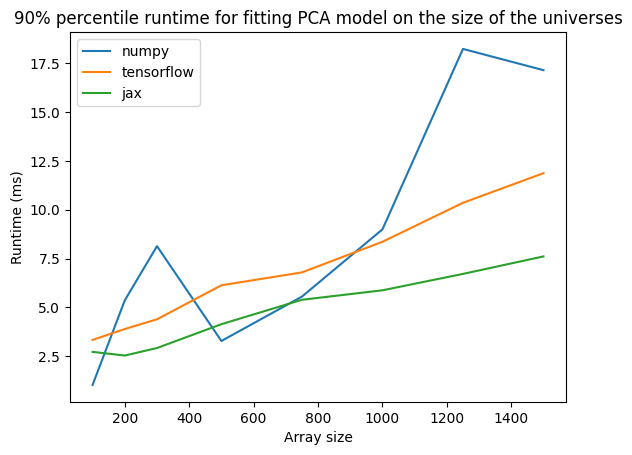

In [19]:
num_of_days = 252 * 5
runtimes_1d = {}

for library in ENGINES:
    runtimes_1d[library] = {}
    for dim in [100, 200, 300, 500, 750, 1000, 1250, 1500]:
        runtime = transform_timeit(library=library, size=(num_of_days, dim))
        runtimes_1d[library][dim] = runtime[0]

ax = pd.DataFrame(runtimes_1d).plot(title="90% percentile runtime for fitting PCA model on the size of the universes")
ax.set_xlabel("Array size")
ax.set_ylabel("Runtime (ms)")